In [36]:
import geopandas as gpd
from tqdm import tqdm
import fiona
import itertools as it

from pyproj import Transformer, CRS, Geod
from shapely.geometry import Point
import matplotlib.pyplot as plt

import osmnx as ox


# From PixC to river profiles

This Tutorial describes how combine the SWOT L2 HR Pixel Cloud product with a river centerline (in this use case from OpenStreetMap) to compute a custom high resolution river profile.  

This example originates from a study presented by Gasnier & Zawadzki at EGU 2025 on the potential of SWOT data on narrow rivers. It is located in China, near Xiaohaizi reservoir.  

*contact to recreate the study: Lionel.Zawadzki@cnes.fr*

# Define the zone of interest

In this example, the zone of interest originates from a river centerline. This centerline may be defined with many different approaches, for instance:
* from the SWOT Prior River Database
* from OpenStreetMap python API
* from the QuickOSM QGIS plugin (same features as the API), then exported in a shapefile or geopackage are similar vector format
* from a user-defined vector/polygon drawn with a GIS software, then exported in a shapefile or geopackage are similar vector format  

In the following example, we are using the OpenStreetMap python API. Here again, there several possibilities. We will define a center point and serach for all river and canal references around this point

In [27]:
# Source Point
source_point = Point(78.89, 39.68)
source_point = (source_point.y, source_point.x)
# type of features we are searching
waterway_list = [
    'river',
    'canal',
    ]
# searching distance around source point
DISTANCE_BUFFER = 1000 #m

gdf_osm_main = ox.features_from_point(
    source_point,
    dist=DISTANCE_BUFFER,
    tags={'waterway': waterway_list},
    )

gdf_osm_main = gdf_osm_main.reset_index()
# you get a geopandas.GeoDataframe object
gdf_osm_main



,element,id,geometry,waterway
0,way,1326050667,"LINESTRING (78.79138 39.66405, 78.79283 39.661...",river


In [13]:
gdf_osm_main.explore()

In this case, we have only one hit but there could be hundreds, we select the feature of interest.

In [ ]:
waterway_id = 1326050667

gdf_osm = gdf_osm_main[gdf_osm_main.id==waterway_id]
# get the CRS corresponding to the feature (UTM)
crs = gdf_osm.estimate_utm_crs()
crs = CRS(crs)


#Read the SWOT file generated by pixcdust

*nb: the SWOT geopackage file has been generated thanks to the pixcdust library, cf dedicated tutorial “Download and convert to Geopackage” in the Intermediary Section.*  
It is basically an extract (space, time, variables) of the SWOT L2 Pixel Cloud product, each layer within the geopackage being the extract of one SWOT PixC tile.  

The area of interest used to generate this geopackage is larger than the ones defined in the present tutorial.

In [32]:
swot_file = '/home/hysope2/STUDIES/chroniques-de-swot/data/xiaohaizi_data.gpkg'

layers = fiona.listlayers(swot_file)

layers

['20230411_487_10_85R',
 '20230412_488_10_85R',
 '20230413_489_10_85R',
 '20230414_490_10_85R',
 '20230415_491_10_85R',
 '20230416_492_10_85R',
 '20230417_493_10_85R',
 '20230418_494_10_85R',
 '20230419_495_10_85R',
 '20230420_496_10_85R',
 '20230421_497_10_85R']

A few functions

In [33]:
from typing import Iterator
from shapely.geometry.linestring import LineString
import shapely as shp
from matplotlib import cm

def get_utm_crs(point: Point):
    
    utm_crs = CRS.from_epsg(32700 - int((point.y + 180) / 6) * 2)
    return utm_crs


def geodesic_distance_along_linestring(line: LineString, target_points: list, crs:None) -> Iterator[float]:
    """
    Compute the geodesic distance along a LineString in meters from a source point to a target point.

    Parameters:
        line (LineString): The LineString along which the distance is computed.
        source_point (Point): The source point.
        target_point (list(Point): The target points).

    Returns:
        float: Geodesic distance along the LineString from source to target point in meters.
    """
    target_points = iter(target_points)
    segments = [LineString([a,b]) for a,b in it.pairwise(line.coords)]
    # Using 3857 here but should use the local UTM crs
    if crs is None: crs = 'EPSG:3857'
    my_transformer = Transformer.from_crs('EPSG:4326', crs, always_xy=True)

    while (point := next(target_points, None)) is not None:
        closest_pt = shp.ops.nearest_points(line, point)[0]

        closest_segment_pts = [shp.ops.nearest_points(seg, point)[0] for seg in segments]
        match = closest_segment_pts.index(closest_pt)

        split_line = shp.LineString(line.coords[0:match+1] + [[closest_pt.x, closest_pt.y]])
        split_line = shp.ops.transform(my_transformer.transform, split_line)
        
        yield split_line.length


def meters_to_degrees(distance_in_meters, crs):
    """
    Convert a geodesic distance in meters to degrees based on the provided CRS.

    Args:
        distance_in_meters (float): The geodesic distance in meters to convert.
        crs (str or pyproj.CRS): The Coordinate Reference System (CRS) in which the distance is measured.

    Returns:
        float: The equivalent distance in degrees.
    """
    if isinstance(crs, str):
        crs = CRS(crs)
    
    # Define a WGS84 CRS for longitude/latitude
    wgs84 = CRS("EPSG:4326")
    
    # Create a transformer from the provided CRS to WGS84
    transformer = Transformer.from_crs(crs, wgs84, always_xy=True)
    
    # Get a point at the origin of the CRS
    lon, lat = transformer.transform(0, 0)

    # Calculate the scaling factor for the given latitude
    degrees = Geod(ellps='WGS84').fwd(lon, lat, 0, distance_in_meters)[1]
    
    return degrees




Constructing a polygon based on the centerline, using a 20m buffer

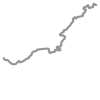

In [34]:
ref_line_osmid = gdf_osm.geometry.values[0]
ref_polygon_path = ref_line_osmid.buffer(
    meters_to_degrees(20, crs)
)
ref_polygon_path

Now for each SWOT tile (layer), we will extract the data in the polygon of interest, compute the distance of each point from the source (first point of the centerline) and save the result in a geopackage.  
You could process several polygons at once

In [ ]:
for layer in tqdm(layers):
    swot = gpd.read_file(
                    swot_file,
                    engine='pyogrio',
                    use_arrow=True,
                    layer=layer
                    )

    swot = swot[swot.intersects(ref_polygon_path)]

    if swot is None:
        continue

    # computing the distance along the river centerline
    swot['distance_cumul'] = list(geodesic_distance_along_linestring(
            ref_line_osmid,
            swot.geometry.tolist(),
            crs
    ))
    # sorting values along river centerline
    swot.sort_values('distance_cumul', ascending=True, inplace=True)
    
    if swot is not None:
        swot.to_file(f'{waterway_id}_pixc.gpkg', layer=layer, driver='GPKG')


100%|██████████| 11/11 [00:41<00:00,  3.77s/it]


Now you can visualize your results on QGIS from the geopackage.

# Let us make some plots out of this data
we will create a plot of wse w.r.t the distance along the river. The time will be represented by different colors

In [ ]:
def init_figure():
    fig, ax = plt.subplots(1,1, figsize=(14,10))
    
    fig.patch.set_facecolor('#FEFEFE')
    fig.patch.set_alpha(0.8)

    ax.set_ylabel('water surface elevation (m)', color='.3')
    ax.patch.set_facecolor('#EFEFEF')
    ax.patch.set_alpha(0.)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for spine in ['left', 'bottom']: 
        ax.spines[spine].set_linewidth(3)
        ax.spines[spine].set_color('.3')
    ax.tick_params(colors='.3')
    
    ax.set_xlabel('along waterway (km)')
    ax.set_ylabel('wse (m)')

    ax.grid(True)
    
    return fig, ax


def plot_waterway_data(data, ax, color='k', ):

    ax.plot(
        data['distance_cumul']/1000.,#km
        data['wse'],
        ls='None',
        marker='o',
        color=color,
        alpha=.7,
        markersize=2,
    )
    
    return
    
    



(1101.0, 1109.0)

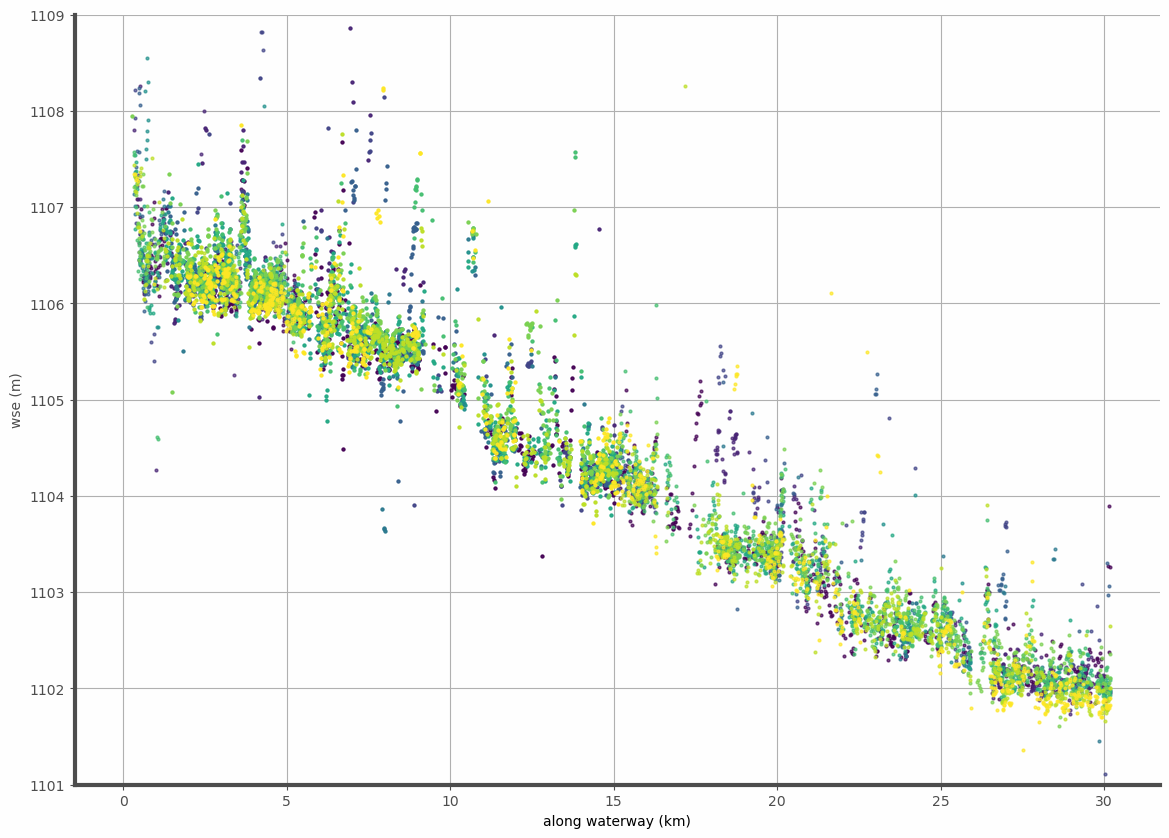

In [50]:
from matplotlib.pyplot import cm
import numpy as np

swot_file_plot = f'{waterway_id}_pixc.gpkg'
# defining color iterator
color = iter(cm.viridis(np.linspace(0, 1, len(layers))))

fig, ax = init_figure()

for layer in sorted(layers):
        # reading layer (tile)
        swot = gpd.read_file(
                        swot_file_plot,
                        engine='pyogrio',
                        use_arrow=True,
                        layer=layer
                        )
        # defining some editing criteria on Sigma0, classification and Water Surface Height range
        swot = swot[
                (swot.sig0>=20)&
                (swot.classification>=3)&(swot.classification<=4)
        ]
        # plotting result
        plot_waterway_data(swot, ax, next(color))
ax.set_ylim([1101, 1109])

Enjoy!  
*L. Zawadzki*